### Bibliotecas:

In [1]:
import pandas as pd #Cria/gerencia dataframes
import pathlib #Usado para gerenciar diretórios 
import numpy as np #Ideal para trabalhar com números e arrays 

import matplotlib.pyplot as plt #Visualização de gráficos 
import seaborn as sns #Deixar o matplotlib visualmente mais agradável

import plotly.express as px #Ideal para visualização dinâmica dos dados

import gc #CONTROLAR USO DE MEMÓMRIA

from sklearn.metrics import r2_score, mean_squared_error #métricas que usaremos para visualizar o nível de precisão dos nossos modelos
#modelos de machine learning que vamos usar
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split 

### Primeiro, importamos nossa base de dados

vamos acrescentar duas colunas separadas: ano e mês, para ter uma divisão de datas mais exata. Acredito que criar uma coluna especial para a data, mais especificamente para o mês, pode nos ajudar, já que dependendo do mês, se é fim de ano, data comemorativa ou algo do tipo, o preço pode mudar bastante.

In [2]:
gc.collect()

meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')#Deixe assim caso o diretório com as bases de dados estejam no mesmo diretório que esse arquivo.

base_airbnb = pd.DataFrame()
dfs = []
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    dfs.append(df)

base_airbnb = pd.concat(dfs, ignore_index=True)

In [3]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


## Tratamentos

- Por ter muitas colunas, é possível que nosso modelo acabe ficando lento demais. Além disso, mesmo que não faça sentido em uma primeira análise, muitas colunas podem mais atrapalhar o resultado final do modelo do que ajudar, já que determinados dados podem ser mal interpretados, como receber um nível de relevância maior do que deveria, e ocasionarem numa análise incoerente.
- Em uma primeira análise sob nossa base de dados é possível notar que várias colunas podem ser consideradas desnecessárias para o nosso modelo de previsão. Por esse motivo, vamos excluir algumas colunas da nossa base para aumentar a eficiência e eficácia do nosso modelo.
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações que parecem não impactar diretamento o preço do imóvel;
    2. Informações repetidas ou extremamente parecidas com outra, Ex: Data x Ano/Mês;
    3. Colunas preenchidas com textos livres. Não será executado nenhumas análise de padrões de palavras ou algo do tipo;
    4. Colunas em que todo ou quase todos os valores são iguais;
    5. Colunas em que eu acho que são desnecessárias para o modelo.


- Para identificar os parâmetros citados acima faremos uma análise qualitativa com os 1000 primeiros registros da nossa base.


In [4]:
base_airbnb.head(1000).to_csv('Primeiros_registros.csv', sep=';')#TRANSFORMA OS PRIMEIROS 1000 VALORES DA BASE DE DADOS NUM ARQUIVO EXCEL 

### Após uma análise qualitativa dos dados, seguindo os critérios acima, as colunas julgadas relevantes foram:

- host_is_superhost: Verdadeiro(t) ou falso(f) se quem está alugando tem credibilidade dentro da plataforma;
- host_listings_count: Número de propriedades que o anfitrião(host) tem disponível na plataforma;
- latitude: Latitude do imóvel;
- longitude: Longitude do imóvel;
- property_type: Tipo de propriedade(casa, apartamento, chalé, etc);
- accommodates: A quantidade máxima de pessoas que podem ser acomodadas no imóvel;
- bathrooms: Quantidade de banheiros;
- bedrooms: Quantidade de quartos;
- beds: Quantidade de camas;
- amenities: Serviços oferecidos pela propriedade (TV, wi-fi, etc); 
- price: Preço (diária);
- security_deposit: Preço exigido como forma de potenciais danos durante a estadia;
- cleaning_fee: Taxa para cobrir os custos associados à limpeza;
- guests_included: Quantos pessoas estão incluidas no preço base;
- extra_people: Taxa adicional para uma quantidade de hospédes maior do que a indicada no guests_included;
- maximum_nights: Número máximo de noites permitidas para a estadia;
- number_of_reviews: Número de avaliações que a propriedade possui;
- review_scores_rating: Classificação da propriedade em relação as avaliações fornecidas;
- review_scores_cleanliness: Avaliação da limpeza da propriedade;
- review_scores_location: Avaliação da localização da propriedade;
- review_scores_value: Avaliação da relação Custo x Benefício da propriedade;
- instant_bookable: t ou f se a propriedade está disponível para reserva imediata;
- cancellation_policy: Categoriza a política de cancelamento do imóvel;
- ano: Ano em que a propriedade esteve disponível para estadia;
- mes: Mês em que a propredade esteve disponível para estadia.

### Vamos agora retirar todas colunas que não estão nessa lista.

In [3]:
colunas = ['host_is_superhost','host_listings_count','latitude','longitude','property_type','accommodates','bathrooms','bedrooms','beds','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','maximum_nights','number_of_reviews','review_scores_rating','review_scores_cleanliness','review_scores_location','review_scores_value','instant_bookable', 'cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_is_superhost,host_listings_count,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,amenities,...,maximum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,ano,mes
0,f,1.0,-22.946854,-43.182737,Apartment,4,1.0,0.0,2.0,"{TV,Internet,""Air conditioning"",Kitchen,Doorma...",...,365,38,91.0,9.0,9.0,9.0,f,strict_14_with_grace_period,2018,4
1,t,2.0,-22.965919,-43.178962,Condominium,5,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,90,205,93.0,9.0,9.0,9.0,t,strict,2018,4
2,f,1.0,-22.985698,-43.201935,Apartment,2,1.0,1.0,1.0,"{TV,""Cable TV"",Wifi,""Air conditioning"",""First ...",...,90,85,95.0,10.0,10.0,9.0,f,strict,2018,4
3,f,3.0,-22.977117,-43.190454,Apartment,3,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,30,208,94.0,10.0,10.0,9.0,f,strict,2018,4
4,t,1.0,-22.983024,-43.214270,Apartment,3,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,1125,200,96.0,10.0,10.0,9.0,t,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,f,0.0,-23.003180,-43.342840,Apartment,4,1.0,0.0,2.0,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",...,1125,0,NaN,NaN,NaN,NaN,f,flexible,2019,9
902206,f,0.0,-22.966640,-43.393450,Apartment,4,2.0,2.0,3.0,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",...,1125,0,NaN,NaN,NaN,NaN,f,flexible,2019,9
902207,f,32.0,-22.962080,-43.175520,Apartment,5,1.0,1.0,2.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,W...",...,1125,0,NaN,NaN,NaN,NaN,f,strict_14_with_grace_period,2019,9
902208,f,0.0,-23.003400,-43.341820,Apartment,4,1.0,1.0,1.0,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",...,1125,0,NaN,NaN,NaN,NaN,f,strict_14_with_grace_period,2019,9


## Tratar valores faltando

- Visualizando os dados percebemos que existe uma grande quantidade de dados faltantes. As colunas com mais de 300.000 valores NaN serão excluídas da análise;
- Para as outras colunas vamos excluir as linhas que contém dados NaN.

In [3]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost       460
host_listings_count     460
latitude                  0
longitude                 0
property_type             0
accommodates              0
bathrooms              1724
bedrooms                850
beds                   2502
amenities                 0
price                     0
guests_included           0
extra_people              0
maximum_nights            0
number_of_reviews         0
instant_bookable          0
cancellation_policy       0
ano                       0
mes                       0
dtype: int64


- Agora as linhas vazias

In [4]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 19)
host_is_superhost      0
host_listings_count    0
latitude               0
longitude              0
property_type          0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
amenities              0
price                  0
guests_included        0
extra_people           0
maximum_nights         0
number_of_reviews      0
instant_bookable       0
cancellation_policy    0
ano                    0
mes                    0
dtype: int64


## Verificar os tipos de dados em cada coluna

- Vamos verficar e modicar as colunas em que o tipo de dado não reflete como o python deveria interpretar aquele dado;
- Para fazer as modificações usares a biblioteca numpy;

In [8]:
print(base_airbnb.dtypes)
print('-'*60)
display(base_airbnb.iloc[0])


host_is_superhost       object
host_listings_count    float64
latitude               float64
longitude              float64
property_type           object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
amenities               object
price                   object
guests_included          int64
extra_people            object
maximum_nights           int64
number_of_reviews        int64
instant_bookable        object
cancellation_policy     object
ano                      int64
mes                      int64
dtype: object
------------------------------------------------------------


host_is_superhost                                                      f
host_listings_count                                                  1.0
latitude                                                      -22.946854
longitude                                                     -43.182737
property_type                                                  Apartment
accommodates                                                           4
bathrooms                                                            1.0
bedrooms                                                             0.0
beds                                                                 2.0
amenities              {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                            $133.00
guests_included                                                        2
extra_people                                                      $34.00
maximum_nights                                     

- Note que o preço e o extra people estão sendo reconhecidos como objeto, ao invés de float. Transformaremos o tipo de dado em float32 por oculpar menos "memória" e por não precisarmos de um tipo de dado que requer uma precisão exorbitadamente grande

In [5]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost       object
host_listings_count    float64
latitude               float64
longitude              float64
property_type           object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
amenities               object
price                  float32
guests_included          int64
extra_people           float32
maximum_nights           int64
number_of_reviews        int64
instant_bookable        object
cancellation_policy     object
ano                      int64
mes                      int64
dtype: object


### Análise Exploratória e Tratar Outliers

Outliers são dados que se diferenciam drasticamente dos outros, um valor que foge da normalidade e que pode causar anomalias no resultado final.

- Vamos basicamente olhar feature por feature para:
    1. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    2. Ver a correlação entre as features e decidir se manteremos todas as features que temos
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

- OBS: durante a análise tomaremos a decisão se é cabível ou não a exclusão dos outliers

- Para realizar tal análise utilizaremos a biblioteca matplotlib

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [6]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

## Analisando coluna Price

C:\Users\User\AppData\Local\Temp\ipykernel_7980\801376575.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


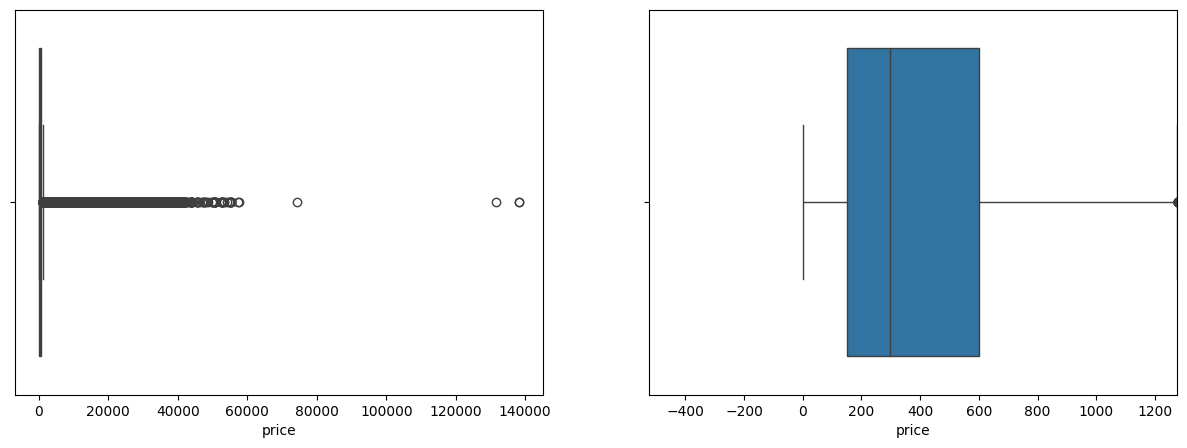

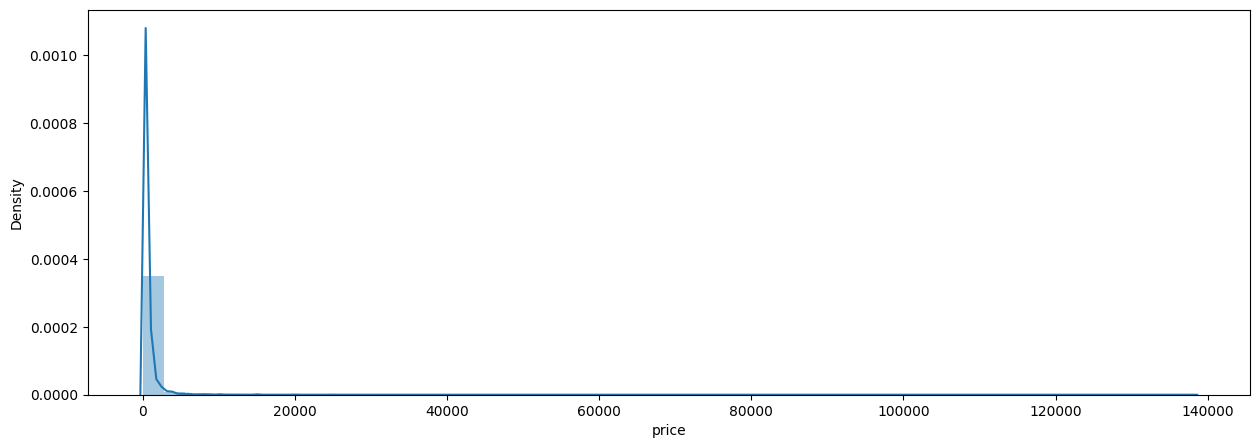

In [11]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

É possível que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [7]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


## Analisando coluna extra_people

C:\Users\User\AppData\Local\Temp\ipykernel_7980\801376575.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


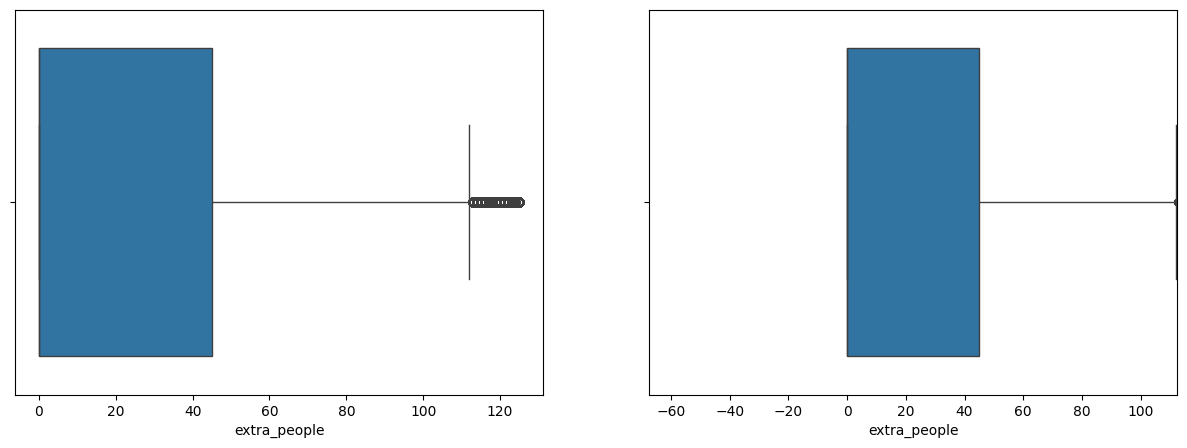

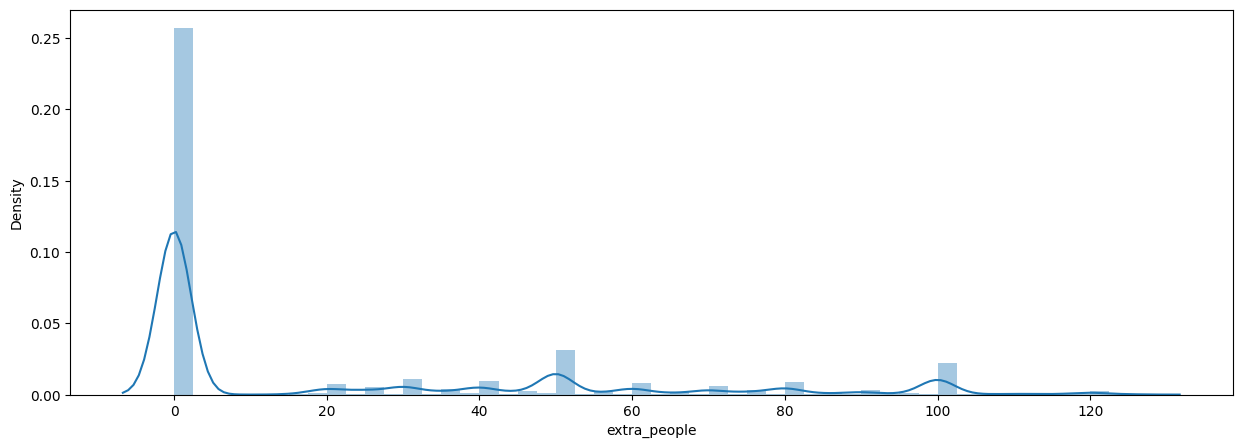

In [16]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

### Quase todos os dados estão concentrados dentro dos limites de outlier, por isso:

In [8]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


## Analisando coluna host_listings_count

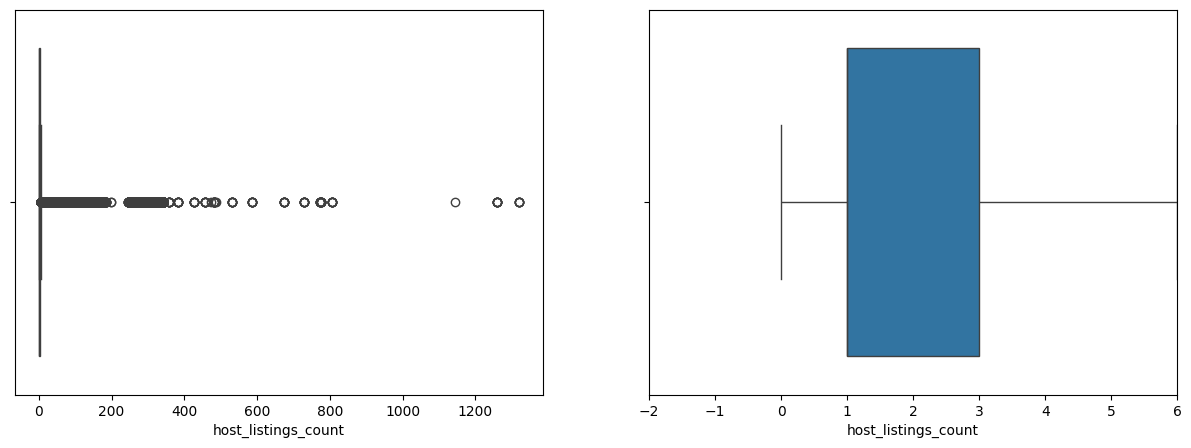

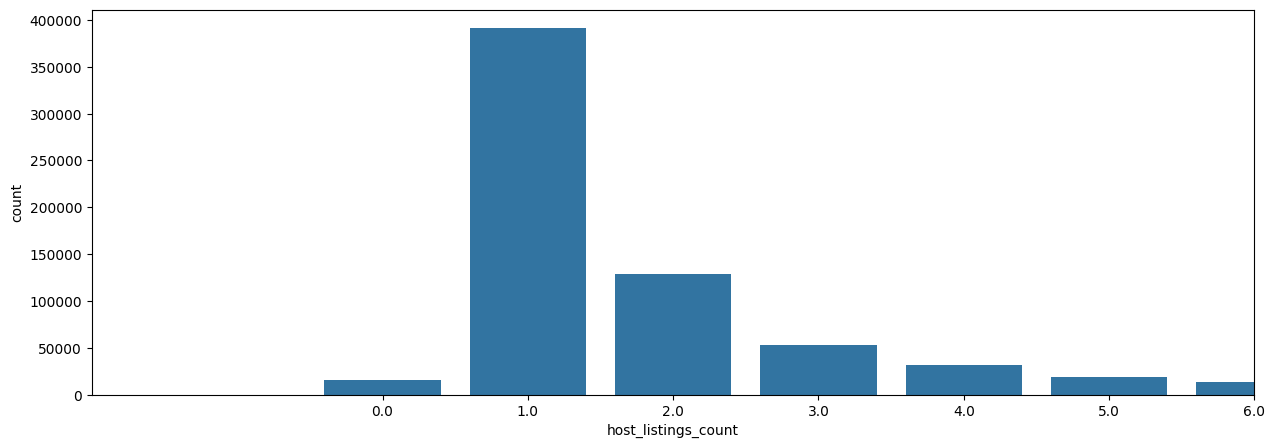

In [15]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

É possível que hosts com mais de 6 imóveis sejam imobiliárias ou profissionais que trabalham nesse negócio, que não são o público alvo do nosso negócio, por isso será retirado os outliers.

In [9]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


## Analisando coluna accommodates

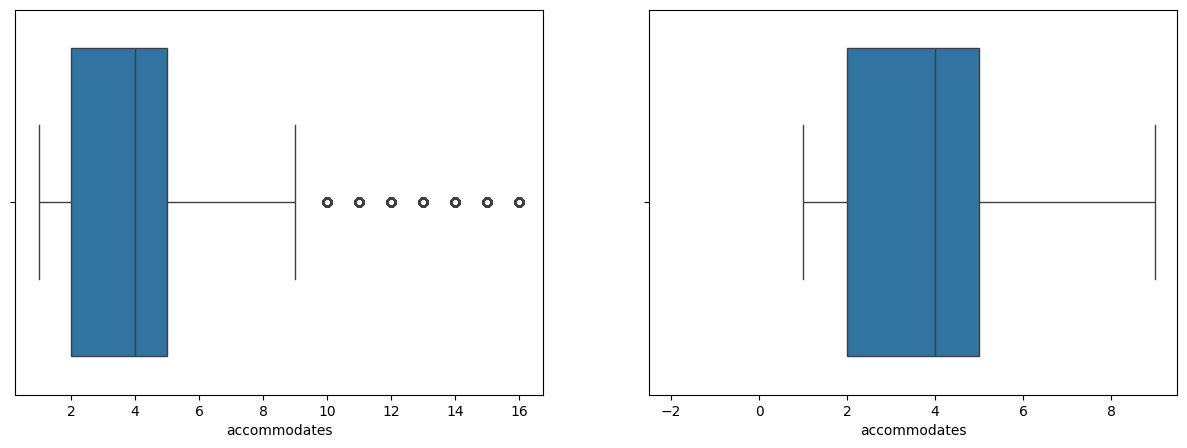

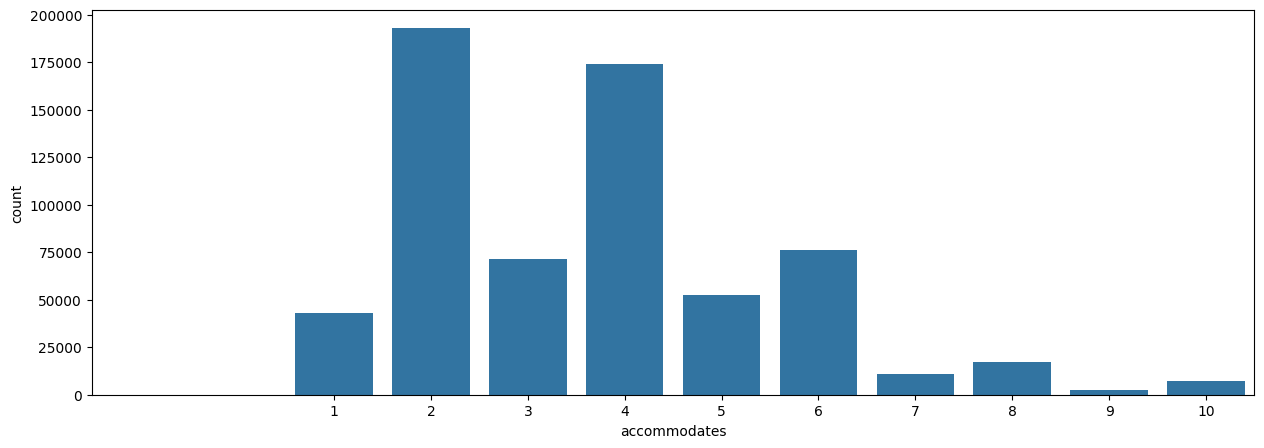

In [18]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderiamos manter esses dados ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [10]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


## Analisando coluna bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

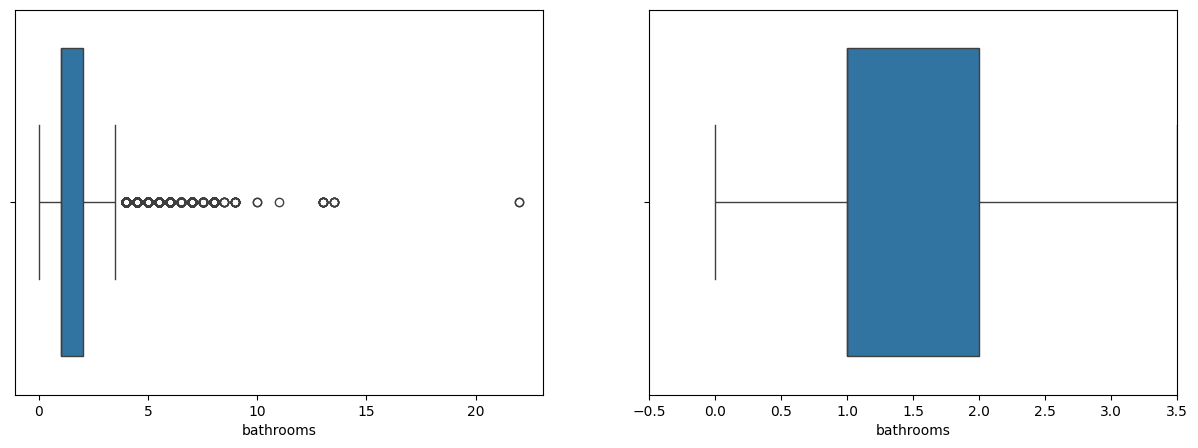

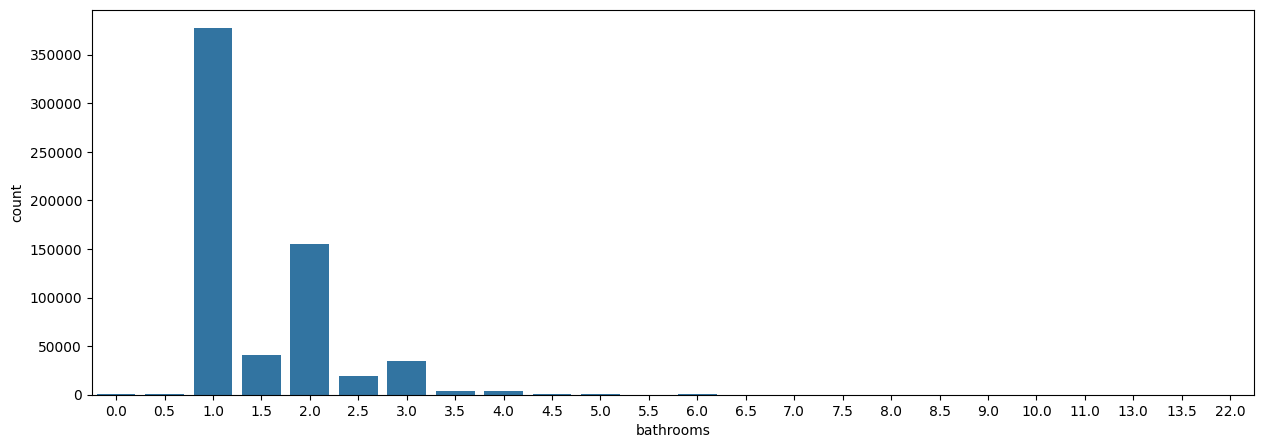

In [20]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers nos banheiros

In [11]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### Analisando coluna bedrooms

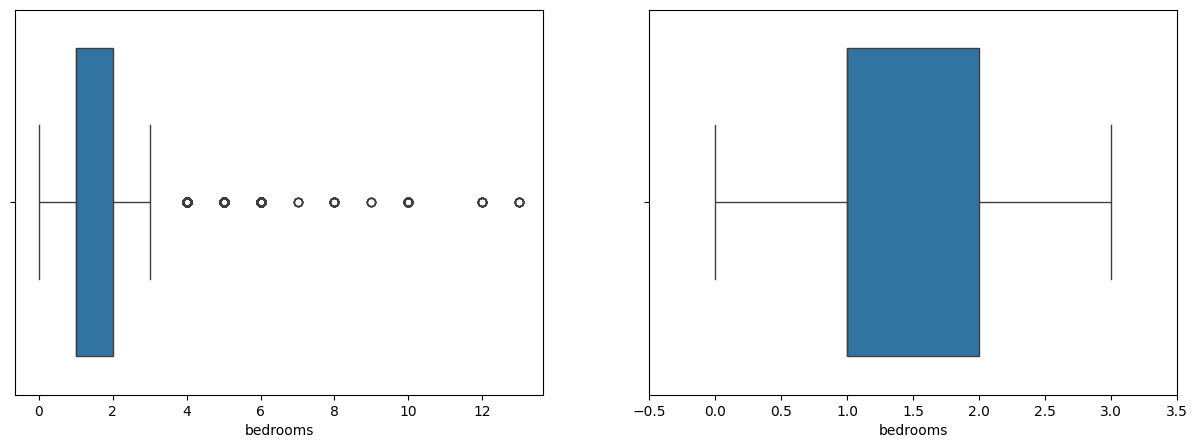

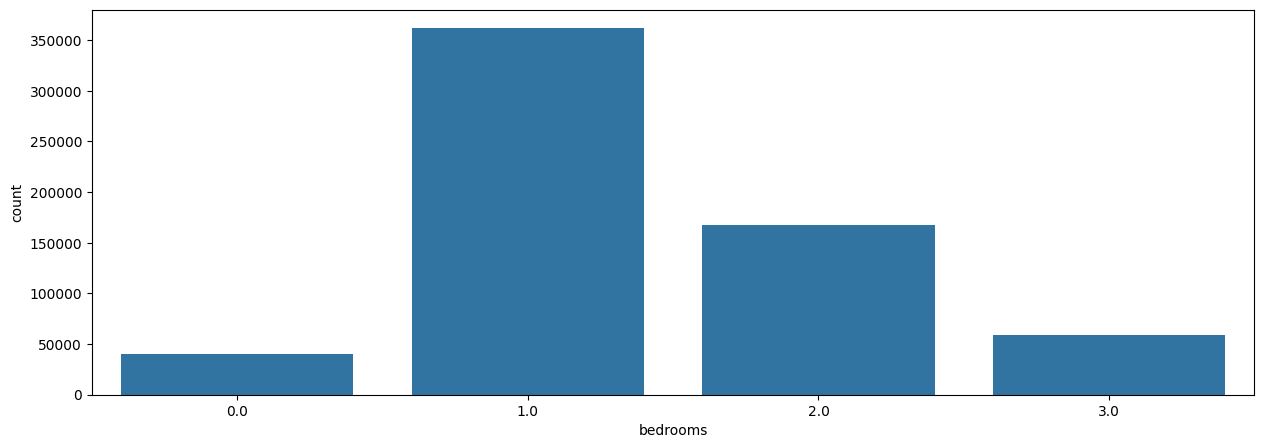

In [22]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [12]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### Analisando coluna beds


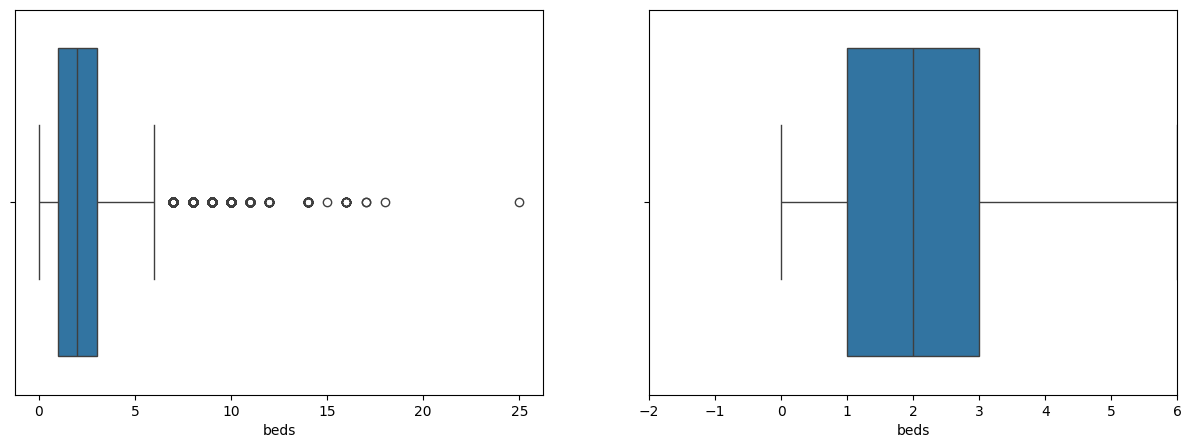

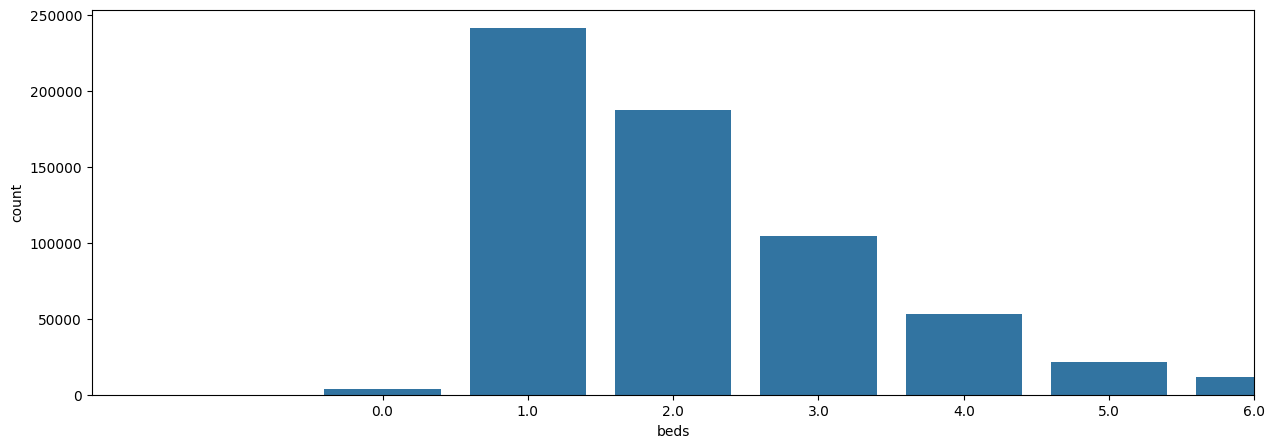

In [24]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### Analisando coluna guests_included

(1.0, 1.0)


<Axes: xlabel='guests_included', ylabel='count'>

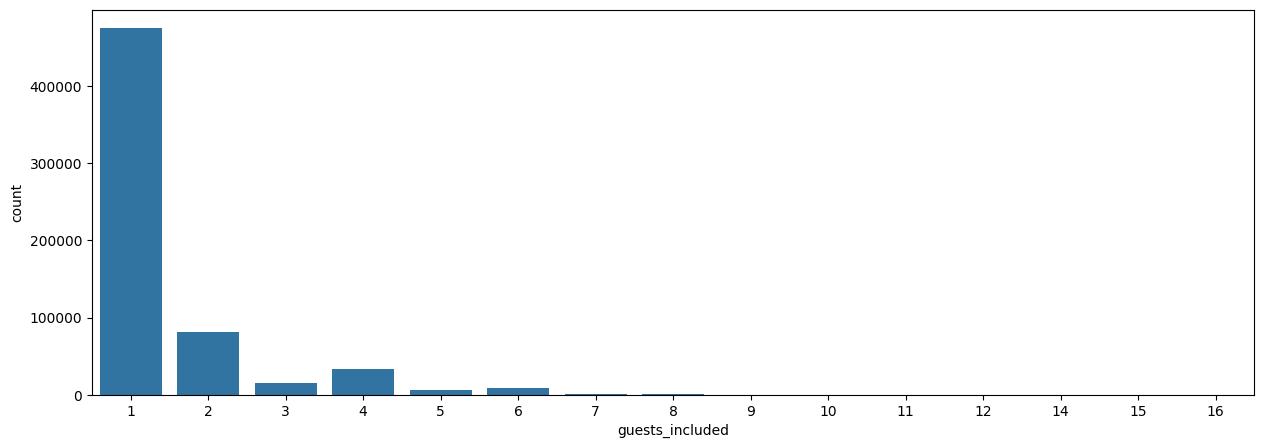

In [26]:
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

- Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, parece melhor excluir a coluna da análise

In [14]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 18)

### Analisando coluna maximum_nights


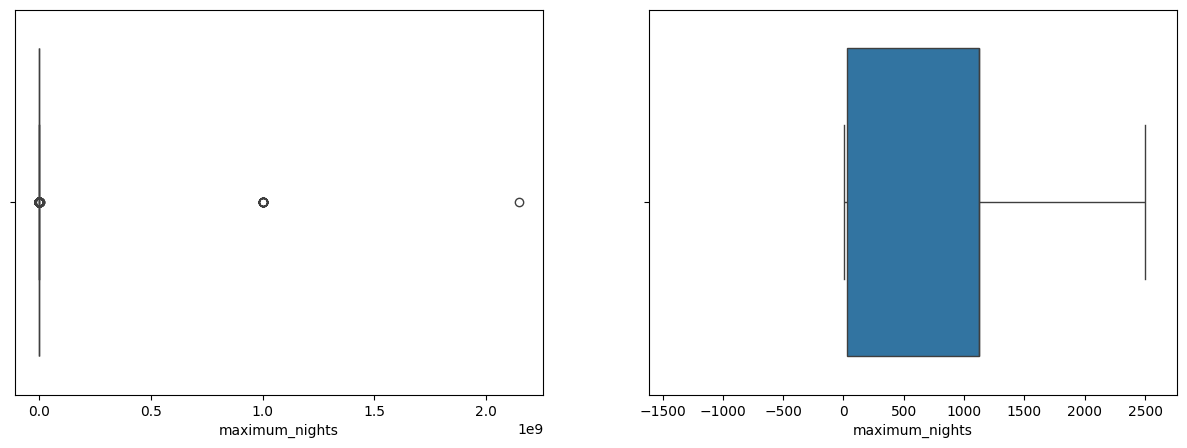

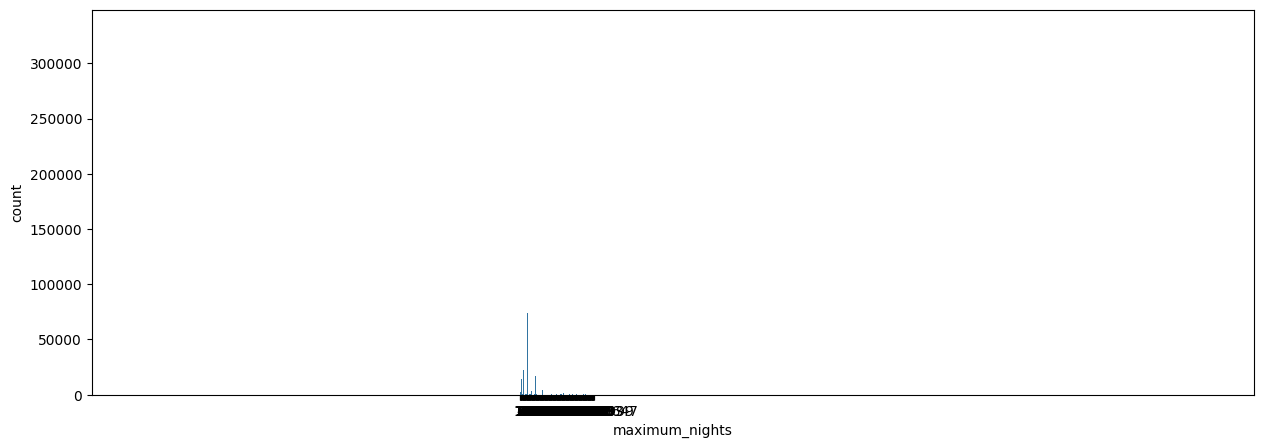

In [28]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [15]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(622366, 17)

### Analisando a coluna numbers_of_reviews


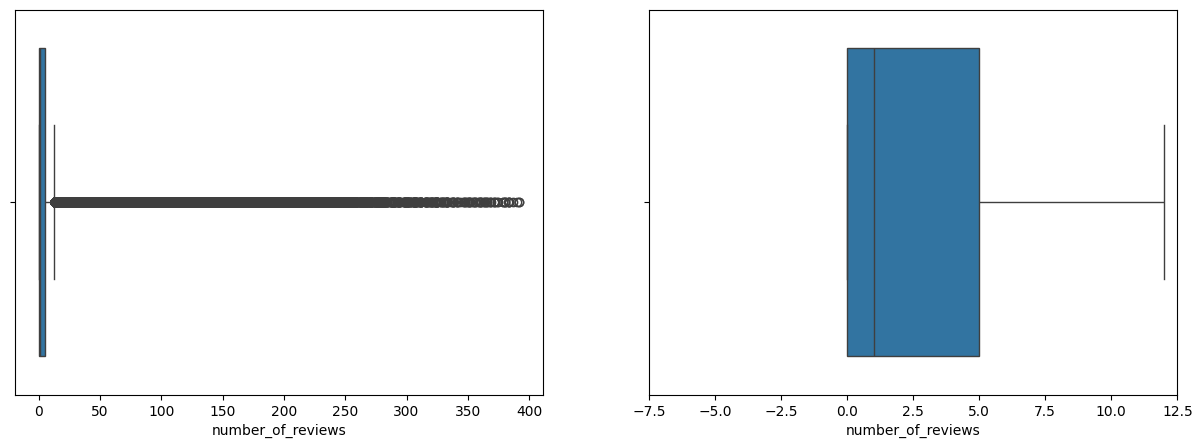

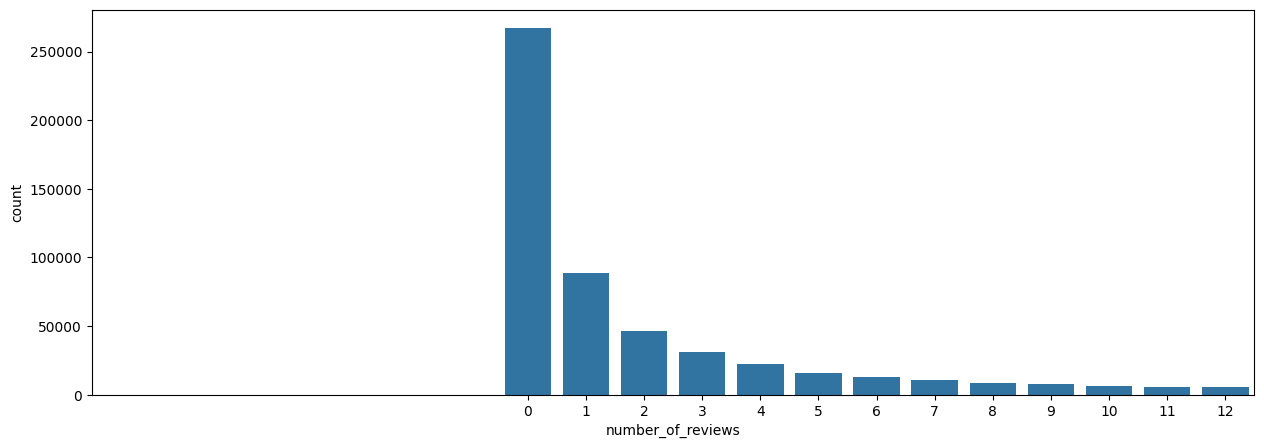

In [30]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Nesta colunas podemos tirar algumas conclusões:
    1. Se excluírmos os outliers estaremos excluindo os hosts que provalvemente mais alugaram seus imóveis, ou seja, os melhores, o que implica que as características de seus imóveis são bons parâmetros para tirar conclusões sob o preço.
    2. Pensando no objetivo principal que é atender um usuário que possuí um imóvel comum e que não tem ideia do preço que quer colocar, é claro que esse usuário não possuirá nenhum tipo de review, ou seja, esse dado seria nulo, o que pode implicar que excluir essa coluna seja o ideal.
    3. Optar pela segunda opção provalvemnte tirará o impacto que o modelo poderia ter para usuários que buscassem saber se o preço de um imóvel está dentro do padrão, já que nesse contexto o imóvel poderia ter algum número de review.

vamos optar pela segunda opção, já que é o objetivo principal do projeto.

In [16]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(622366, 16)

## Tratamento de colunas com valores de texto

### Analisando coluna property_type

property_type
Apartment                 492790
House                      54273
Condominium                27679
Serviced apartment         13151
Loft                       12787
Guest suite                 3748
Bed and breakfast           3522
Hostel                      2839
Guesthouse                  2237
Other                       2070
Villa                       1384
Townhouse                   1032
Aparthotel                   720
Earth house                  545
Tiny house                   489
Chalet                       481
Boutique hotel               449
Hotel                        376
Casa particular (Cuba)       328
Cottage                      247
Bungalow                     213
Dorm                         191
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Boat                          65
Island                        54
Hut                           40
Campsite                     

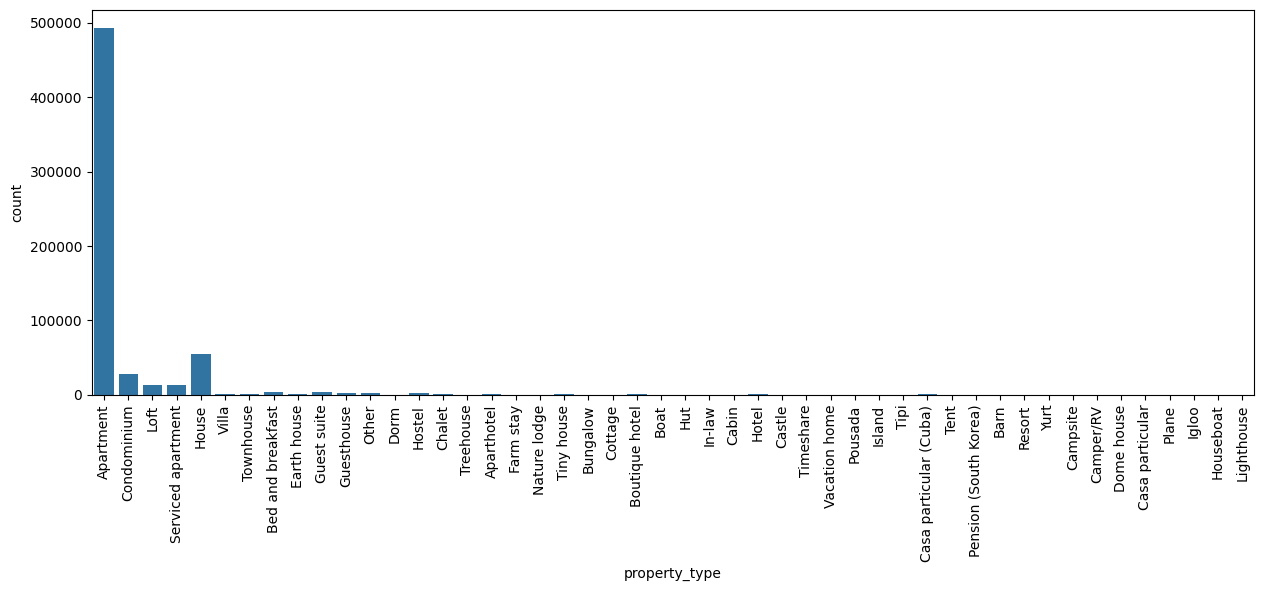

In [32]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Como se trata de um coluna de texto não vamos excluir os outliers, mas sim agrupar valores muito pequenos em uma única categoria;
- Todas as cetegoria de tipo de propriedade que tiver menos de 2000 propriedades na base de dados serão agrupadas em um grupo chamado outros. Isso vai facilitar com que o nosso modelo chegue num resultado mais conclusivo, pois não terá que levar em consideração valores muito pequenos como algo totalmente independente.

['Villa', 'Townhouse', 'Aparthotel', 'Earth house', 'Tiny house', 'Chalet', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Boat', 'Island', 'Hut', 'Campsite', 'Resort', 'Tent', 'Camper/RV', 'Yurt', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Houseboat', 'Timeshare', 'Casa particular', 'Pousada', 'Plane', 'Lighthouse']
property_type
Apartment             492790
House                  54273
Condominium            27679
Serviced apartment     13151
Loft                   12787
Outros                  9340
Guest suite             3748
Bed and breakfast       3522
Hostel                  2839
Guesthouse              2237
Name: count, dtype: int64


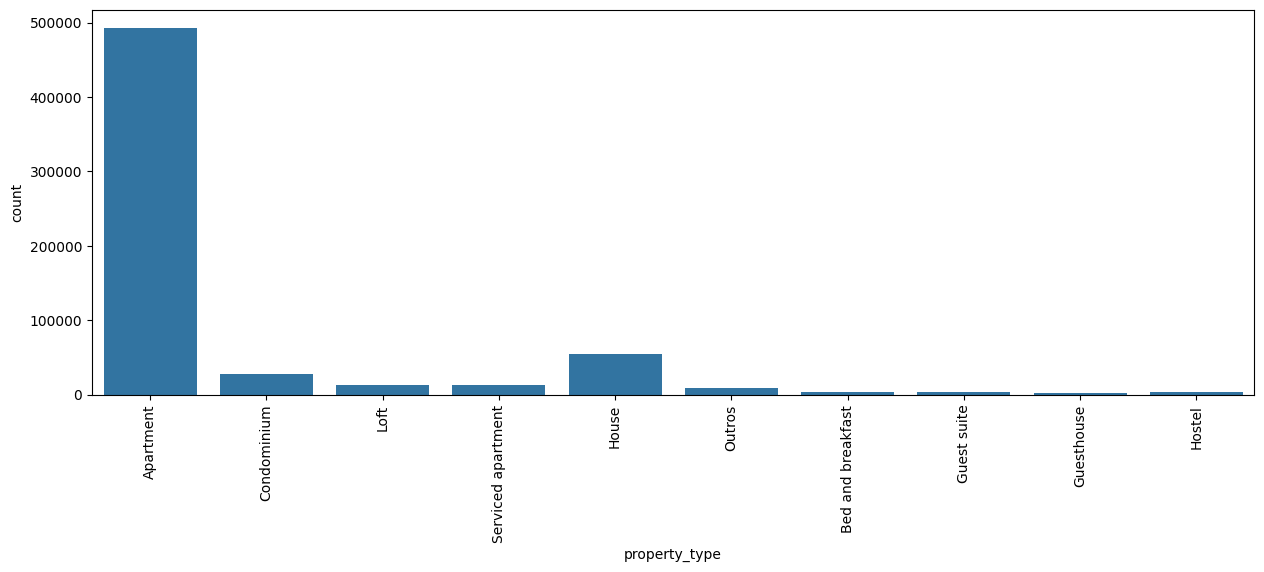

In [17]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
tipos_retirar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        tipos_retirar.append(tipo)
print(tipos_retirar)

for tipo in tipos_retirar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

base_airbnb.loc[base_airbnb['property_type'] == 'Other', 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### Analisando coluna cancelattion_policy

cancellation_policy
flexible                       282175
strict_14_with_grace_period    212280
moderate                       117567
strict                          10177
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


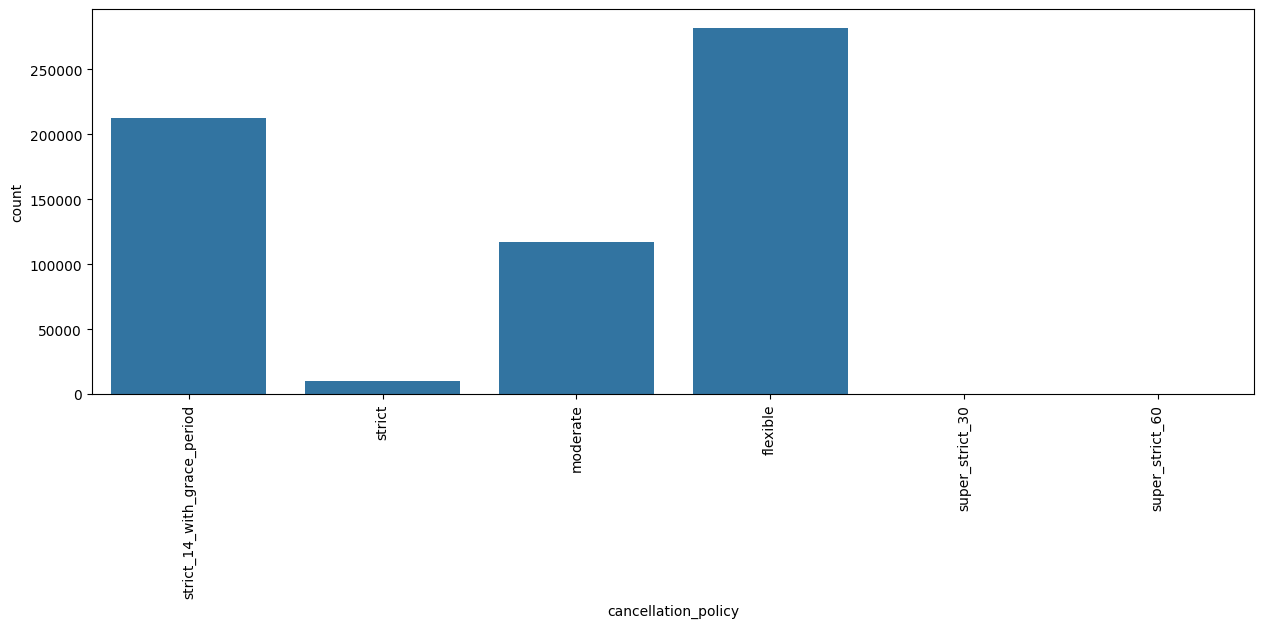

In [34]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Vamos agrupar as categoria que possuem a quantidade de registros menores do que a categoria "strict"

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       282175
strict_14_with_grace_period    212280
moderate                       117567
strict                          10344
Name: count, dtype: int64


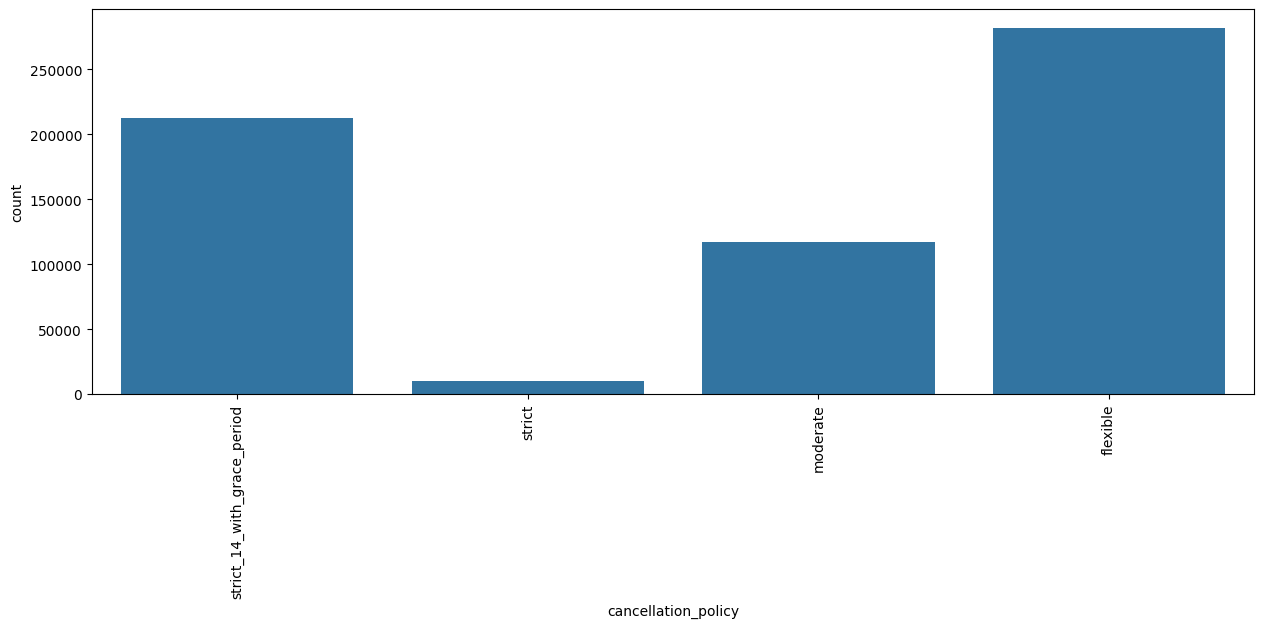

In [18]:
# agrupando categorias de cancellation_pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] <= 10177:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### Analisando coluna ameneties

Analisando a coluna de ameneties podemos notar que muitos que estão em uma linha estão apenas escritos de uma maneira  diferente, além de possuir uma diversidade muito grande. Analisar item por item poderia dar muito trabalho e necessitaria fazer uma análise de textos que foge do objetivo desse projeto, sendo assim, vamos considerar a quantidade de amenities como o parâmetro para o nosso modelo.


In [19]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(622366, 16)

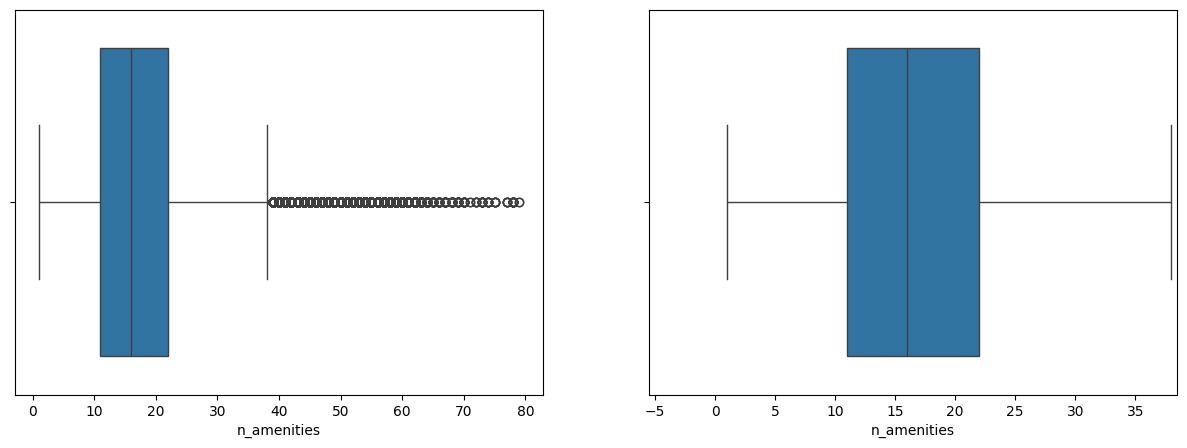

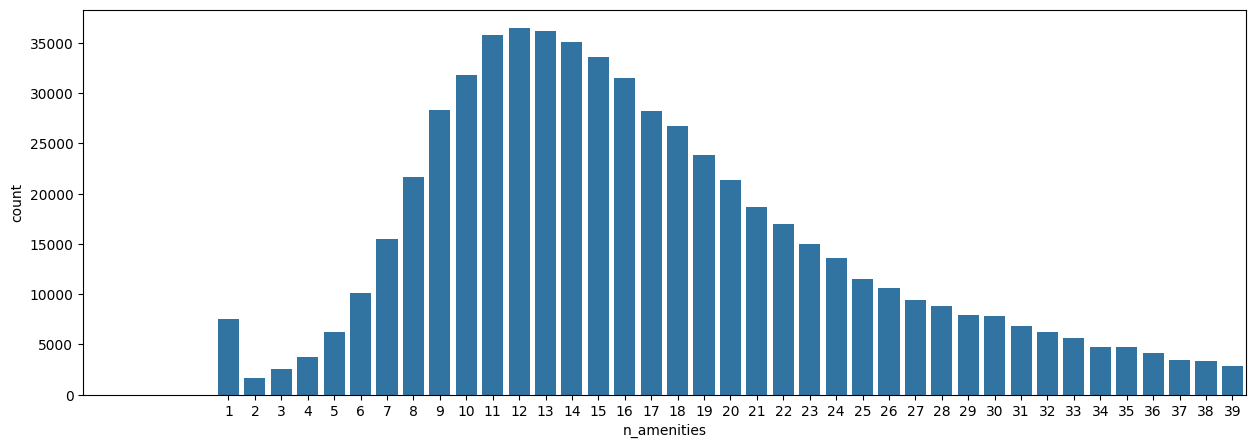

In [37]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24839 linhas removidas


### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [ ]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

#O OUTPUT DESTA CÉLULA NÃO ESTÁ APARECENDO POIS O MAPA OCUPA UM ESPAÇO DE MEMÓRIA CONSIDERÁVEL, MAS O CÓDIGO ESTÁ CORRETO. 

Ao visualizar o mapa notamos que imóveis com preços mais altos se encontram em áreas específicas do Rio, o que significa que a localização, em especial as colunas de latitude e longitude podem ser extremamente relevantes para o nosso modelo.

## Encoding

Precisamos, agora, ajustar os tipos de dados, pois os modelos de machining learning que vamos utilizar aqui não aceitam parâmetros textuais, apenas numéricos.
Para realizar tais ajustes, vamos:

- Colunas de valores true or false, vamos mudar para 1 e 0 respectivamente.
- Colunas de categoria vamos utilizar o processo de encoding de variáveis dummy, já que não temos tantas colunas desse tipo, o que não na criação de uma quantidade exorbitante de colunas.
    - A codificação de variáveis dummy envolve a criação de novas colunas binárias (0 ou 1) para representar cada categoria única da variável original.

In [21]:
colunas_tf = ['host_is_superhost', 'instant_bookable']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [22]:
colunas_categorias = ['property_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Loft,property_type_Outros,property_type_Serviced apartment,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,0,1.0,-22.946854,-43.182737,4,1.0,0.0,2.0,133.0,34.0,...,False,False,False,False,False,False,False,False,False,True
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,False,False,False,False,False,False,False,False,True,False
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,False,False,False,False,False,False,False,False,True,False
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,False,False,False,False,False,False,False,False,True,False
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,False,False,False,False,False,False,False,False,True,False


### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor.

Vamos calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o resultado, melhor.

In [23]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados

    1. RandomForest: A Random Forest é um modelo de ensemble que utiliza múltiplas árvores de decisão para realizar previsões. Cada árvore de decisão é treinada em uma amostra aleatória do conjunto de dados. Durante a previsão, as árvores individuais emitem suas previsões e a média (no caso de regressão) ou a votação (no caso de classificação) é considerada como a previsão final. Isso ajuda a reduzir o overfitting e aumenta a estabilidade do modelo.

    2. LinearRegression: A regressão linear é um modelo que busca estabelecer uma relação linear entre uma variável de saída (dependente) e uma ou mais variáveis de entrada (independentes).
    
    3. Extra Tree: Assim como na Random Forest, várias árvores são treinadas em amostras aleatórias do conjunto de dados. A diferença está na escolha dos cortes para as divisões nas árvores: ao invés de procurar a melhor divisão, o Extra Trees usa divisões aleatórias. Isso pode levar a uma maior variabilidade, mas pode ser benéfico em alguns conjuntos de dados.
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhi esses 3 modelos por nenhum motivo em específico, apenas pesquisei e vi que para o objetivo do nosso projeto eles se encaixarão perfeitamente.



In [24]:
del ano 
del arquivo
del meses
del base_airbnb
del colunas
del colunas_agrupar
del colunas_categorias
del df
del dfs
del tabela_cancellation
del tabela_tipos_casa
del tipos_retirar
#EXCLUIMOS ALGUMAS VARIÁVEIS PARA LIBERAR MEMÓRIA

modelo_rf = RandomForestRegressor()
#modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

#VOU RETIRAR O LINEAR REGRESSION PARA OCUPAR MENOS MEMÓRIA DURANTE O TREINAMENTO DOS OUTROS DOIS MODELOS, MAS EU TESTEI ESSE MODELO SOZINHO E OS RESULTADOS FORAM: Modelo LinearRegression:
#R²:32.76%
#RSME:226.26
#o que era de esperar, já que uma característica desse modelo e ser mais rápido do que os outros, mas muito menos preciso.

modelos = {'RandomForest': modelo_rf,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

### Separar os dados em treino e teste + Treino do Modelo

Esta etapa é crucial. É nessa etapa que as IAs aprendem.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior). Então, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços. Depois que ele aprende, você faz um teste com ele com a parcela dos dados que foi separada para isso, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo.

In [25]:
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)#colocamos um random_state para caso quisermos otimizar nosso modelo, usaremos a mesma parcela de dados

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))  

Modelo RandomForest:
R²:97.37%
RSME:44.72
Modelo ExtraTrees:
R²:97.49%
RSME:43.71


Como o modelo ExtraTress regressor foi o o modelo que obteve os melhores resultados em ambos as métricas de previsão utilizadas, além de ter sido ligeiramente mais rápido do que o modelo RandomForest, escolheremos ele como nosso modelo para estudar melhor.

### Otimizando o modelo escolhido

In [26]:
del modelo_rf
#del modelo_lr RODE ESSA LINHA CASO TENHA TREINADO O LINEAR REGRESSION JUNTO COM OS OUTOS

.feature_importances_ descreve para gente qual o nível de importância/relevância cada coluna teve para gerar o resultado final. A ordem que as colunas estão apresentadas ao dar um print é a mesma ordem das colunas que foram utilizadas no "X", tanto o X de treino, quanto o de teste. Dessa forma:

,0
bedrooms,0.136939
latitude,0.131363
longitude,0.130867
n_amenities,0.109867
accommodates,0.102261
extra_people,0.096304
bathrooms,0.071854
beds,0.062574
host_listings_count,0.039355
instant_bookable,0.018933


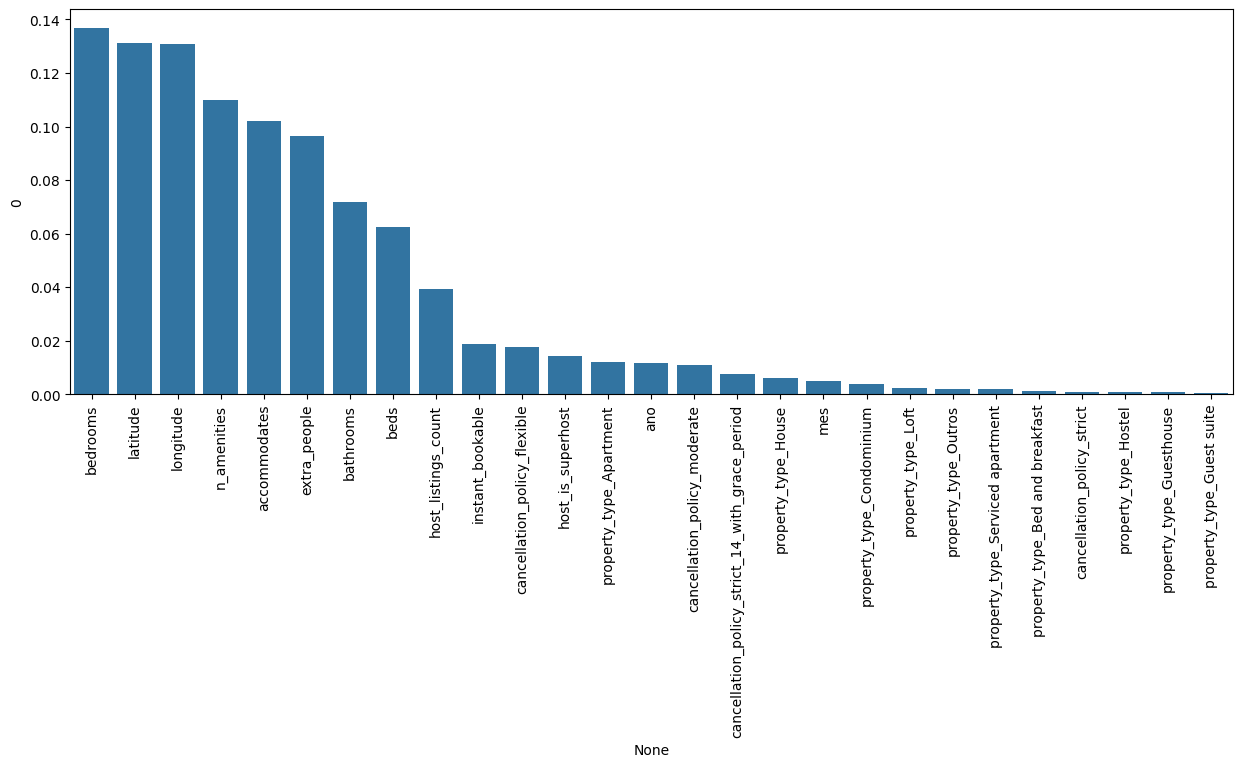

In [27]:
rel_columns = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
rel_columns = rel_columns.sort_values(by=0, ascending=False)
display(rel_columns)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=rel_columns.index, y=rel_columns[0])
ax.tick_params(axis='x', rotation=90)

Otimizar o modelo, mesmo que ele já esteja bom, é bom para torna-lo mais rápido e, principalmente, com uma capacidade de generalização maior, ou seja, a capacidade de chegar nos mesmos resultados ou em resultados semelhantes utilizando informações muito mais comuns dos diversos casos que podemos nos deparar.

Analisando o gráfico podemo tirar algumas conclusões:

- De fato, a latitude e longite foram extremamentes importantes para o nosso modelo;
- Outras colunas como: número de camas, número de quartos, banheiros e etc também foram muito relevantes para o modelo, o que á algo que já poderiamos esperar, já que, normalmente, são as coisas que as pessoas mais levam em conta;
- A coluna ano teve mais impacto do que a coluna de mês, o que é o contrário das minhas expectativas, já que eu imaginei que o mês teria um impacto maior por especificar datas comemorativas. Uma hipótese que pode explicar tal fenônemo seja por que a base de dados vai até 2020, ano em que começou a pandemia do Covid-19, dessa forma, imóveis que foram alugados em 2020 tiveram bastante oscilação em relação aos anos anteriores;
- A política de cancelamento "stritc" também não se mostrou muito importante, diferentemente daquela que possui um prazo de carência ("cancellation_pollicy_strict_14_with_grace_period"), o que pode significar que a maioria dos imóveis possue algum tempo para que a política de cancelamento, mesmo que rígida, seja efetivada. O que pode acalmar as pessoas e deixarem elas mais confortáveis para alugar o imóvel;
- O tipo de propriedade que não seja, condomínio, casa ou apartamento demonstrou não impactar muito no preço. Eu acredito que isso acontece pois a maioria dos imóveis são apenas um desses três tipos e, até mesmo, imóveis que apresentem até outras características, como "property_type_Serviced apartment", ainda sim são selecionados apenas como uma dessas opções pelos hosts, ou apenas como "Outros".

Diante disso, acredito que retirar todas as colunas:
- property_type_Serviced apartment;
- property_type_Bed and breakfast;
- cancellation_policy_strict;
- property_type_Hostel;
- property_type_Guesthouse;
- property_type_Guest suite.

pode ser um bom meio de otimizar nosso modelo.

Vamos ver quais são os resultados do modelo ao retirar essas colunas, se o valor for igual ou maior, diremos que esse novo modelo é melhor, se o valor for menor, analisaremos o quão menos preciso ele é, já que, mesmo que menos preciso, ele pode compensar por ser muito mais simples e veloz;

In [31]:
base_airbnb_cod = base_airbnb_cod.drop('property_type_Serviced apartment', axis=1)
base_airbnb_cod = base_airbnb_cod.drop('property_type_Bed and breakfast', axis=1)
base_airbnb_cod = base_airbnb_cod.drop('cancellation_policy_strict', axis=1)
base_airbnb_cod = base_airbnb_cod.drop('property_type_Hostel', axis=1)
base_airbnb_cod = base_airbnb_cod.drop('property_type_Guesthouse', axis=1)
base_airbnb_cod = base_airbnb_cod.drop('property_type_Guest suite', axis=1)

In [32]:
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTreesRegressor', y_test, previsao))

Modelo ExtraTreesRegressor:
R²:97.47%
RSME:43.92


Note que esse novo modelo obteve resultados quase que idênticos ao original, obtendo uma diferença de aproximadamente 0,02% no R² e menos de 0,5% no RSME, além de ter demorado quase que a metade do tempo do original. Sendo assim, acredito que por ter resultados muito parecidos e ainda ser muito mais eficiente na questão do tempo, o modelo já apresenta uma melhora significativa e suficiente para o nosso objetivo.